In [612]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import warnings
import category_encoders as ce
import impyute
from impyute.imputation.cs import mice

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, log_loss, roc_curve

import imblearn
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)


pd.options.mode.chained_assignment = None

plt.style.use('bmh')
pd.set_option('display.max_colwidth', -1)

# 1. Exploratory Data Analysis (EDA)

In [470]:
df_orig = pd.read_csv("data/challenge3_train.csv")
df_orig.head(5)

,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,1,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,1,0,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,2,0,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,3,0,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,4,1,NaN,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


We start by removing the 'id' and the 'target' columns, as the first is simply a unique ID for each row, and the second is the target variable. 

In [471]:
id_ = df_orig[['id']]
target = df_orig[['target']]
df = df_orig.drop(columns=['id', 'target'])
print(f'Data has {df.shape[0]} rows, each with {df.shape[1]} features.')
df.head(5)

Data has 50000 rows, each with 31 features.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,13.9681,3.0,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,14.0242,0.0,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,14.2174,0.0,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,13.8536,0.0,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,NaN,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,14.2347,0.0,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


## 1.1 Missing values
First we check the distribution over missing values for the different features (columns). 

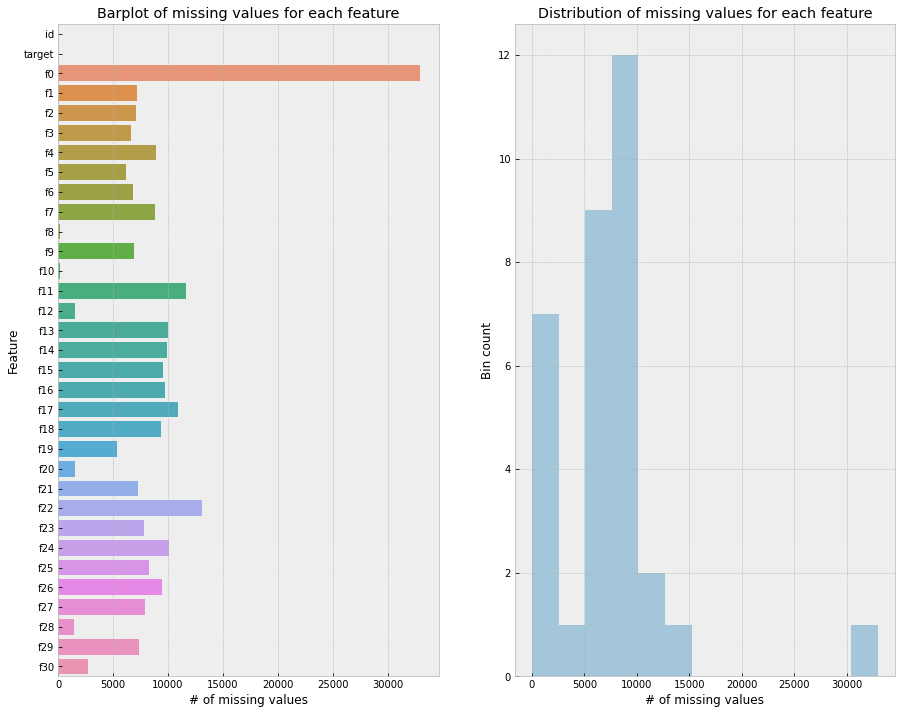

In [472]:
missing_values = df_orig.isna().sum()
fig, ax = plt.subplots(1,2, figsize=(15, 12))
sns.barplot(missing_values.values, missing_values.index, ax=ax[0])
ax[0].set_title("Barplot of missing values for each feature")
ax[0].set_xlabel('# of missing values')
ax[0].set_ylabel('Feature');

sns.distplot(missing_values.values, ax=ax[1], kde=False)
ax[1].set_title("Distribution of missing values for each feature")
ax[1].set_xlabel('# of missing values')
ax[1].set_ylabel('Bin count');


**On the left we see a barplot over the number of missing values for each feature. We observe that almost every feature have very many missing values. Therefore, we should spend quite some time investigating how to best impute the missing values.**

There are still features with many missing values, which needs to be handled. Before we get to that, we explore the different feature types.

## 1.2 Feature types (continuous vs discrete)
We want to find which features are continuous and which are discrete. This is important because we want to fill in missing values differently depending on the variable is continuous or discrete. As an example, if a feature represented salary, it could make sense to impute missing values using the mean. But for a discrete feature, such as the number of cars a person owns, it does not make sense to impute using mean, as this will most likely result in persons having a 'illegal' (fractional) number of cars (1.3 cars, for instance). 

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      17024 non-null  float64
 1   f1      42852 non-null  float64
 2   f2      42885 non-null  float64
 3   f3      43352 non-null  float64
 4   f4      41089 non-null  float64
 5   f5      43792 non-null  object 
 6   f6      43176 non-null  float64
 7   f7      41138 non-null  float64
 8   f8      49855 non-null  float64
 9   f9      43135 non-null  float64
 10  f10     49840 non-null  float64
 11  f11     38383 non-null  float64
 12  f12     48487 non-null  object 
 13  f13     40023 non-null  float64
 14  f14     40132 non-null  float64
 15  f15     40430 non-null  object 
 16  f16     40238 non-null  float64
 17  f17     39102 non-null  float64
 18  f18     40592 non-null  float64
 19  f19     44658 non-null  float64
 20  f20     48488 non-null  object 
 21  f21     42717 non-null  float64
 22

From this we observe that we have mostly numerical values (float64), and some categorical non-numerical values (object). This divides the data into numeric and non-numeric features.

In [474]:
numerical_features = [c for c in df.columns if df[c].dtype == 'float64'] # df.select_dtypes('float64')# 
non_numerical_features = [c for c in df.columns if df[c].dtype == 'object']

In [475]:
print(f'Numerical features:\n{numerical_features} \n')
print(f'Categorical features:\n {non_numerical_features}')


Numerical features:
['f0', 'f1', 'f2', 'f3', 'f4', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f13', 'f14', 'f16', 'f17', 'f18', 'f19', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f29', 'f30'] 

Categorical features:
 ['f5', 'f12', 'f15', 'f20', 'f28']


#### Non-numerical features
Let's check the distributions for each non-numerical feature. This is useful to know when we later will encode them into numerical values.

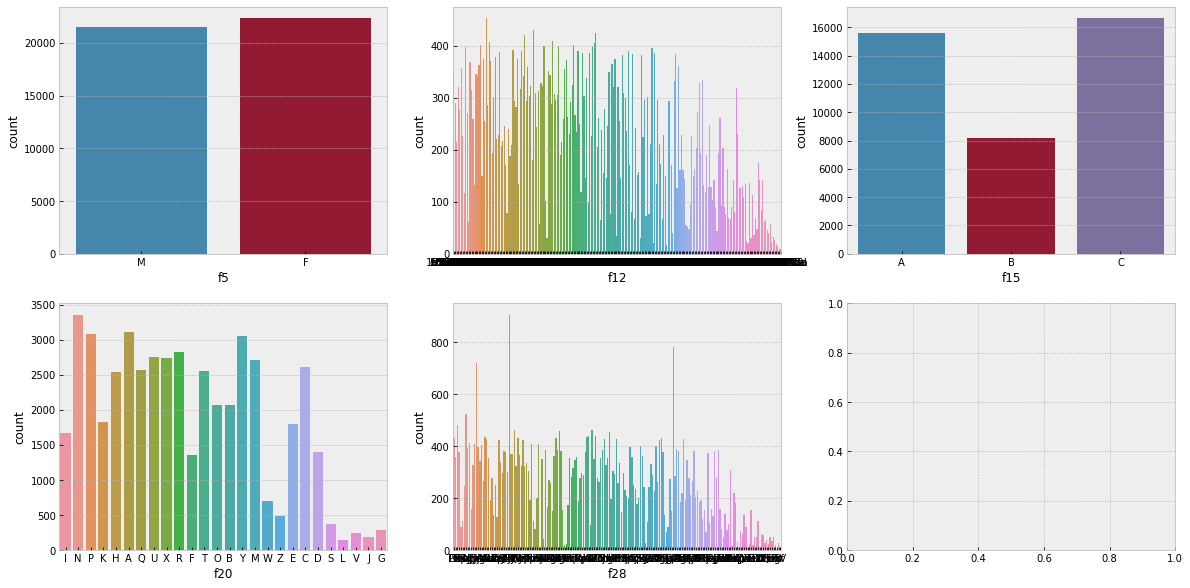

In [476]:
# sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for variable, subplot in zip(non_numerical_features, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    #for label in subplot.get_xticklabels():
     #   label.set_rotation(90)

In [477]:
print(f'f12 has {df["f12"].nunique()} unique values')
print(f'f28 has {df["f28"].nunique()} unique values')

f12 has 222 unique values
f28 has 190 unique values


#### Numerical features
Let's check the distributions for each numerical feature.

In [478]:
# df[numerical_features].hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

From above it seems like only 9 of the numerical features are continuous (f4, f7, f8, f10, f13, f14, f16, f22 and f30). The rest can be threated as discrete features. These discrete features may or may not have a natural ordering of their values, that is, they can be ordinal or nominal. Because we do not have feature names available, it is hard to know which are ordinal and which are ordinal.  

We also observe that 'f30' has a lot of '-1' values, a number typically used to denote 'missing value'. Therefore we should converte these to NaNs. 
We also observe that some of the continuous features have very many zero values (f10, f14). It might be the case that the value zero is used to denote 'missing value' for these features (altough this is not so usual). However, we will make a method that will work on a particular column, and replace specific values with the NaN value. 

In [479]:
def replace_with(df, column, value, replace_value=np.nan):
    # print(f'[{column}] Replacing {value}s with {replace_value}')
    df2 = df.copy()
    df2[column] = df2[column].apply(lambda v: replace_value if v == value else v)
    return df2

In [480]:
#df = replace_with(df, 'f30', -1)
#df = replace_with(df, 'f10', 0)
#df = replace_with(df, 'f14', 0)

## 1.3 Correlations between numerical values 
It may be useful to look at the correlation between the numerical features. To do so we plot a heatmap and creates some methods for getting the top correlated features. 

#### Splitting into discrete and continuous features

First let's define a method that divides the features into continuous and discrete data. We treat features that have less than a certain threshold number of unique values as discrete, and the rest as continuous. 

In [481]:
def get_discrete_and_continuous_feature(df, threshold=300):
    df2 = df.copy()
    discrete_cols = [c for c in df2.columns if df2[c].nunique() <= threshold]
    cont_cols = [c for c in df2.columns if df2[c].nunique() > threshold]
    return discrete_cols, cont_cols
    

In [482]:
discrete_cols, cont_cols = get_discrete_and_continuous_feature(df)
print(f'Discrete features: {discrete_cols}')
print(f'Continuous features: {cont_cols}')

Discrete features: ['f0', 'f1', 'f2', 'f3', 'f5', 'f6', 'f9', 'f11', 'f12', 'f13', 'f15', 'f17', 'f18', 'f19', 'f20', 'f21', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29']
Continuous features: ['f4', 'f7', 'f8', 'f10', 'f14', 'f16', 'f22', 'f30']


In [483]:
df_corr = df.copy().dropna()
df_corr[discrete_cols] = df_corr[discrete_cols].apply(lambda x : pd.factorize(x)[0])
corr_matrix = df_corr.corr(method='pearson', min_periods=1)
corr_matrix.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
f0,1.000000,0.093782,-0.009954,0.148188,-0.240476,-0.007619,-0.163921,-0.178334,-0.191601,-0.038581,-0.060577,-0.011275,-0.095854,0.063799,-0.088032,-0.143352,-0.084727,-0.117604,-0.117604,-0.028960,-0.127009,-0.028960,-0.070020,0.025636,0.007381,-0.101356,-0.212079,-0.035787,-0.127147,-0.130867,0.044612
f1,0.093782,1.000000,0.109936,0.146333,-0.099343,-0.128216,-0.001860,-0.085556,0.035470,-0.116404,0.115638,-0.067557,-0.004513,-0.054481,0.108383,0.034296,-0.039456,0.121137,0.121137,0.119495,-0.071459,0.119495,0.113824,0.237992,0.100216,0.013148,0.003605,0.052826,-0.024735,-0.094833,0.069382
f2,-0.009954,0.109936,1.000000,-0.032097,0.185802,-0.025192,0.002230,-0.059935,0.035417,0.039484,0.215137,0.059550,0.174766,0.149692,0.234642,-0.004673,0.045138,0.199108,0.199108,-0.070386,0.117340,-0.070386,0.215847,0.178725,0.368692,-0.083431,0.014470,0.475674,0.170920,-0.080250,0.058586
f3,0.148188,0.146333,-0.032097,1.000000,-0.134303,0.191031,0.033132,0.037672,0.113403,0.032976,-0.024866,0.024969,0.007312,0.053842,-0.045875,0.065853,0.186160,-0.034975,-0.034975,0.102034,-0.081786,0.102034,0.098915,0.011615,-0.120396,-0.041037,-0.030212,0.030588,-0.034761,-0.074572,0.074034
f4,-0.240476,-0.099343,0.185802,-0.134303,1.000000,-0.100208,0.112844,0.153668,0.057299,-0.026119,-0.094448,0.047397,0.180428,0.122784,-0.069726,0.131648,-0.005187,0.208363,0.208363,0.056076,0.130316,0.056076,0.043384,-0.165917,0.101641,-0.091699,-0.230914,0.006872,0.088585,0.037789,0.071821
f5,-0.007619,-0.128216,-0.025192,0.191031,-0.100208,1.000000,0.092729,0.081320,-0.018789,0.076722,-0.104523,0.042804,0.133177,0.051792,-0.122806,0.111349,-0.029717,-0.056526,-0.056526,0.099498,0.104751,0.099498,-0.077792,-0.021729,-0.017125,0.066007,-0.103092,-0.094887,0.134925,-0.036525,0.064911
f6,-0.163921,-0.001860,0.002230,0.033132,0.112844,0.092729,1.000000,-0.056604,0.023387,0.025446,-0.101656,0.065473,0.183849,0.057514,-0.100581,0.969490,0.069443,-0.213647,-0.213647,0.497880,0.009024,0.497880,-0.019175,-0.317653,-0.064343,0.612862,-0.067035,0.062160,0.121983,0.078170,0.012049
f7,-0.178334,-0.085556,-0.059935,0.037672,0.153668,0.081320,-0.056604,1.000000,0.068699,0.063736,-0.056794,0.095766,-0.031037,-0.100372,-0.057486,-0.044199,-0.010255,0.024892,0.024892,-0.023708,-0.077369,-0.023708,0.042780,-0.032304,0.053893,0.000265,-0.151318,0.022986,-0.013022,-0.101297,0.007749
f8,-0.191601,0.035470,0.035417,0.113403,0.057299,-0.018789,0.023387,0.068699,1.000000,0.006623,0.149373,-0.053738,-0.043865,-0.018011,0.169014,0.035781,0.072834,0.054202,0.054202,0.068567,-0.008896,0.068567,0.078844,-0.102435,-0.081588,-0.094959,0.000732,0.081465,-0.015763,-0.170342,0.015818
f9,-0.038581,-0.116404,0.039484,0.032976,-0.026119,0.076722,0.025446,0.063736,0.006623,1.000000,-0.032300,0.225347,0.074977,-0.046779,-0.019075,0.002120,0.013201,0.072867,0.072867,-0.034683,-0.015299,-0.034683,-0.047205,0.155639,-0.051615,-0.039790,-0.039547,0.113796,0.090492,0.431551,0.027785


By inspecting the heatmap we observe that many features have a very high correlation. We can use this when imputing missing values.

In [484]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr_matrix, n=5):
    au_corr = corr_matrix.unstack()#df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(corr_matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr_matrix, 10))

Top Absolute Correlations
f19  f21    1.000000
f17  f18    1.000000
f10  f14    0.979322
f6   f15    0.969490
     f25    0.612862
f15  f25    0.536934
     f19    0.531021
     f21    0.531021
f12  f28    0.513254
f6   f21    0.497880
dtype: float64


From this we see that the following features have a very high correlation:

    1. f19 and f21
    2. f17 and f18
    3. f10 and f14
    4. f6 and f15

In the next section we will use this to impute missing values for one from each pair, then drop the counterpart. 
There are two reasons to why we choose to drop one of them:
1. For linear models (e.g. logistic regression), multicolinearity can yield solutions that are wildly varying and possibly numerically unstable.
2. Tree-based models (e.g. decision tree, random forest) can be good at detecting interactions between different features, but highly correlated features can mask these interactions.

More generally, this can be viewed as a special case of Occam's razor. A simpler model is preferable [(1)](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features).

In [594]:
def get_correlation_map(df2, col1, col2):
    print(f'-- {col1} vs {col2} --')
    df = df2.copy()
    df = df.loc[:, [col1, col2]]
    for i in sorted(df[col1].dropna().unique()):
        value_count = df.loc[df[col1] == i, col2].value_counts().to_dict()
        print(i, value_count)


In [595]:
print(get_correlation_map(df, 'f19', 'f21'))
print(get_correlation_map(df, 'f17', 'f18'))
print(get_correlation_map(df, 'f6', 'f15'))

-- f19 vs f21 --
0.0 {2.0: 7102}
1.0 {5.0: 5097}
3.0 {4.0: 8983}
4.0 {1.0: 6428}
5.0 {3.0: 10563}
None
-- f17 vs f18 --
0.0 {2.0: 3497}
1.0 {5.0: 8332}
3.0 {4.0: 11620}
4.0 {1.0: 2107}
5.0 {3.0: 6194}
None
-- f6 vs f15 --
0.0 {'C': 950, 'A': 765, 'B': 76}
1.0 {'C': 5275}
2.0 {'B': 5716}
3.0 {'A': 6076}
4.0 {'C': 4390, 'A': 3413, 'B': 685}
5.0 {'C': 3739, 'A': 3247, 'B': 580}
None


For the pairs (f19, f21) and (f17, f18) we know have a one-to-one mapping. Let's use this to impute missing values and then drop the counterpart.

In [619]:
f19_21_map = {0: 2, 1: 5, 3: 4, 4: 1, 5: 3}
f17_18_map = {0: 2, 1: 5, 3: 4, 4: 1, 5: 3}

def impute_based_on_map(df, col1, col2, mapping):
    df3 = df.copy()
    #display(df3)
    df3 = df3[df3[col2].isnull()]
    nan_idx = df3[df3[col2].isnull()].index
    #display(df3[[col1, col2]])
    df3.loc[nan_idx, col2] = df3[col1].apply(lambda x: mapping[x] if not np.isnan(x) else x)
    #display(df3[[col1, col2]])
    return df3

display(df.iloc[:, 15:25].head())
df3 = impute_based_on_map(df, 'f19', 'f21', f19_21_map)
df3.iloc[:, 15:25].head()

,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,A,0.858315,3.0,4.0,5.0,I,3.0,14.2364,0.0,NaN
1,NaN,0.616743,0.0,2.0,5.0,N,3.0,NaN,2.0,3.0
2,A,0.711389,3.0,4.0,5.0,P,NaN,NaN,2.0,2.0
3,A,NaN,4.0,NaN,1.0,K,5.0,NaN,2.0,1.0
4,B,0.572781,0.0,2.0,NaN,H,5.0,13.9537,4.0,5.0


,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
2,A,0.711389,3.0,4.0,5.0,P,3.0,NaN,2.0,2.0
8,NaN,0.559368,3.0,NaN,5.0,A,3.0,NaN,2.0,3.0
10,B,1.014095,3.0,4.0,3.0,X,4.0,13.9805,2.0,NaN
11,A,0.720881,5.0,3.0,0.0,Q,2.0,14.1681,2.0,1.0
19,C,0.789379,NaN,4.0,3.0,K,4.0,NaN,1.0,3.0


In [ ]:
def impute_using_correlated_column(df2, col1, col2, feat_type='discrete'):
    df = df2.copy()
    num_nans1 = df[col1].isna().sum()
    num_nans2 = df[col2].isna().sum()
    # Impute for the col with fewest nans
    if num_nans1 < num_nans2:
        source_feat = col2
        target_feat = col1
    else:
        source_feat = col1
        target_feat = col2
    
    if feat_type = 'discrete':
        model = LogisticRegression(max_iter=100)
    else:
        model = LinearRegression(max_iter=100)
    
    
    filtered_df = df[df[target_feat].notnull()]
    train_x = 
    
    
    
    

In [19]:
df.drop(columns=['f14'], inplace=True)
numerical_features.remove('f14')


In [12]:
df.drop(columns=['f12', 'f28'], inplace=True)

# 2. Data Preprocessing

## 2.1 Handle missing values
As we have seen from our EDA, missing data is a large issue for our dataset.
There are several approaches for handling missing values.

##### Impute using correlation with other features
The first thing we should do is to use features that has very high correlation to impute missing values. As we saw earlier, some features even have 1.0 in correlation, which means that by knowing one of them, we can infer the other. 

For rest of the missing values we have different options.
##### For continuous features we consider the following methods:
- Mean/Median Imputation
- K-nearest neighbours Imputation
    - Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.
- Iterative Imputation (MICE: Multivariate Imputation by Chained Equations)
    - In Iterative Imputation each variable to be filled with missing values are treated as the dependent variable in a regression, with the other remaining variables as its predictors. It cycles through these models, fitting each in turn, then samples from the gaussian predictive posterior of the fitted estimator for each imputation [(2)](https://www.statsmodels.org/stable/imputation.html) [(3)](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer).

##### And for discrete features we consider the following methods:
- Frequent Categorical Imputation
    - Each nan value gets replaced with the most frequent value for that feature.
- Predictive
    - For each feature, a classifier is trained using the other features. This classifier then predicts the nan values for that particular feature.
    
We also try using an extra column for each feature, which tells which values for that feature that was originally a NaN value and has been filled in. The argument here is that this makes it possible for the model to weight non-imputed and imputed observations differently. 

#### Choose imputation combination
Later on we try out different combinations of these imputations in order to pick the combination that works best. 

#### Imputation based on correlation

#### Continuous features
We continue by filling in missing values for the continuous features. First we show why it is usually better to apply more sophisticated methods than a simple mean imputation. Let's use 'f22' as an example.

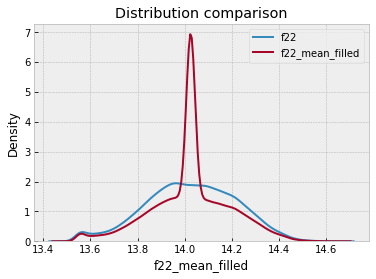

In [22]:
mean_imputation_df = df.copy()
feat = 'f22'
mean_imputation_df['f22_mean_filled'] = mean_imputation_df[feat].fillna(df[feat].mean())

sns.distplot(mean_imputation_df[feat], hist=False, label=feat)
sns.distplot(mean_imputation_df['f22_mean_filled'], hist=False, label='f22_mean_filled')
plt.legend()
plt.title('Distribution comparison');

We observe that left and right side are reasonably close, but there is a significant difference in distributions is in the center, because mean imputation will just set all missing values to the mean. Now we will use Multivariate Imputation for comparison.

In [23]:
# imputed = mice(df[cont_cols].values)
start = time.time()
mice_imputation_df = df.copy()
imp = IterativeImputer(max_iter=10, random_state=0, 
                       sample_posterior=True, n_nearest_features=3)
imputed = imp.fit_transform(mice_imputation_df[numerical_features])
print(f'Imputed after {int(time.time()-start)}s')

Imputed after 189s


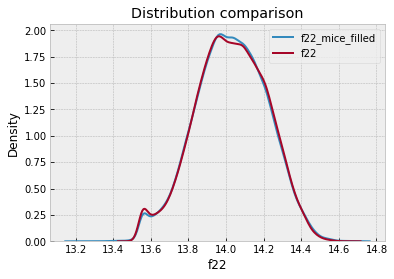

In [24]:
idx = mice_imputation_df[numerical_features].columns.tolist().index('f22')
mice_f22 = imputed[:, idx]
sns.distplot(mice_f22, hist=False, label='f22_mice_filled')
sns.distplot(mice_imputation_df[feat], hist=False, label=feat)
plt.legend()
plt.title('Distribution comparison');

We observe that using the Iterative Imputer the distribution of the imputed values is much closer to the original distribution. Let's make a general general method for this. 

In [225]:
def impute_continuous_features(df, target_feature_names, pretrained_imp=None, method='mice', add_nan_columns=True, verbose=True):
    """
    Args:
        - target_feature_names: the features to fill in NaN values for
        - method: the imputation method to use
    """

    start = time.time()
    df2 = df.copy()
    
    discrete_cols, cont_cols = get_discrete_and_continuous_feature(df2)    
    feature_df = df2.select_dtypes('float64')

    if pretrained_imp is not None:
        imputed = pretrained_imp.transform(feature_df)
        for feat in target_feature_names:
            idx = feature_df.columns.tolist().index(feat)
            if add_nan_columns:
                df2[f"{feat}_Imputed"] = np.where(df2[feat].isnull(), 1, 0)
            df2[feat] = imputed[:, idx]
        return imp, df2
    
    if method == 'mice':
        imp = IterativeImputer(max_iter=10, 
                               sample_posterior=True)
        #feature_df = df2.copy()
        #feature_df[discrete_cols] =  feature_df[discrete_cols].apply(lambda x: pd.factorize(x)[0])# pd.factorize(feature_df[discrete_cols]) # feature_df[discrete_cols].fillna(0)
        imputed = imp.fit_transform(feature_df)

    elif method == 'knn':
        imp = KNNImputer(n_neighbors=2, weights="uniform")
        imputed = imp.fit_transform(feature_df)
        
    elif method == 'mean':
        imp = SimpleImputer(strategy='mean')
        imputed = imp.fit_transform(feature_df)
    
    elif method == 'median':
        imp = SimpleImputer(strategy='median')
        imputed = imp.fit_transform(feature_df)
    
    for feat in target_feature_names:
        idx = feature_df.columns.tolist().index(feat)
        if add_nan_columns:
            df2[f"{feat}_Imputed"] = np.where(df2[feat].isnull(), 1, 0)
        df2[feat] = imputed[:, idx]
    
    if verbose:
        print(f'Imputation done after {int(time.time()-start)}s')
    return imp, df2

Let's compare each imputation method for all the continuous features.

In [26]:
#feature_df = df.select_dtypes('float64')
imp, df_imputed_mean = impute_continuous_features(df, cont_cols, method='mean')
imp, df_imputed_median = impute_continuous_features(df, cont_cols, method='median')
#imp, df_imputed_knn = impute_continuous_features(df, feature_df, cont_cols, method='knn')
imp, df_imputed_mice = impute_continuous_features(df, cont_cols, method='mice')

Imputation done after 0s
Imputation done after 0s
Imputation done after 198s


In [27]:
def plot_imputations(df, df_imputed, cont_cols):
    fig, ax = plt.subplots(2, 3, figsize=(20, 7))
    for variable, subplot in zip(cont_cols, ax.flatten()):
        sns.distplot(df[variable], hist=False, label='Without nan', ax=subplot)
        sns.distplot(df_imputed[variable], hist=False, label=f'Filled', ax=subplot)
        subplot.set_yticks([])
        subplot.legend()

#### Mean Imputer

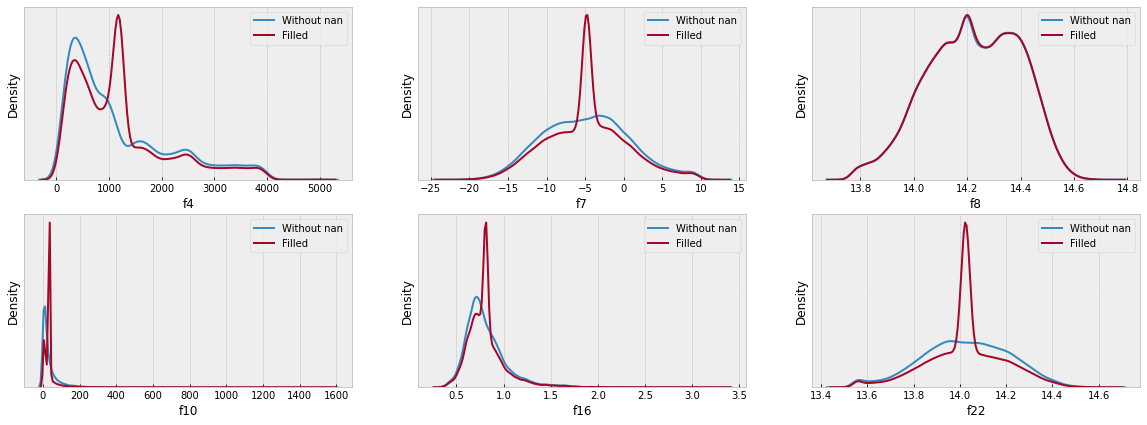

In [28]:
plot_imputations(df, df_imputed_mean, cont_cols)

#### Median Imputer

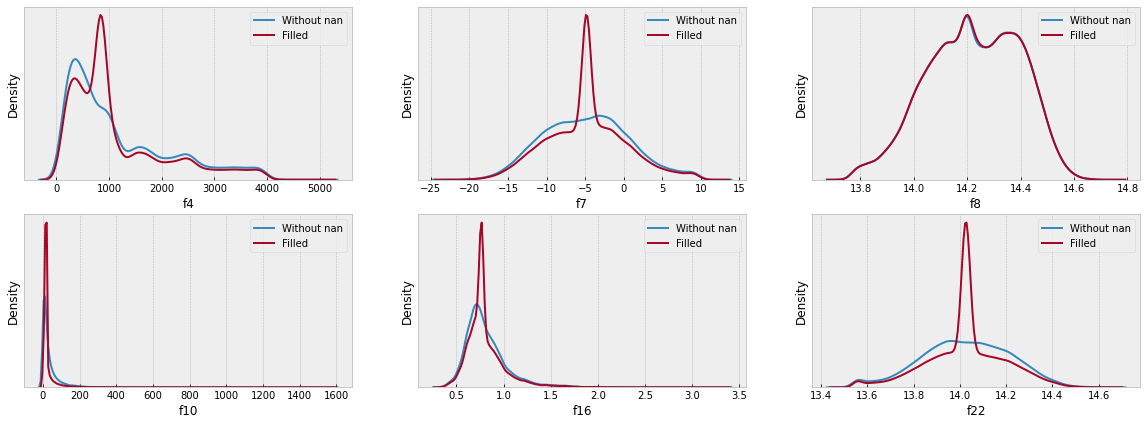

In [29]:
plot_imputations(df, df_imputed_median, cont_cols)

#### KNN Imputer

In [30]:
plot_imputations(df, df_imputed_knn, cont_cols)

NameError: name 'df_imputed_knn' is not defined

#### MICE Imputer

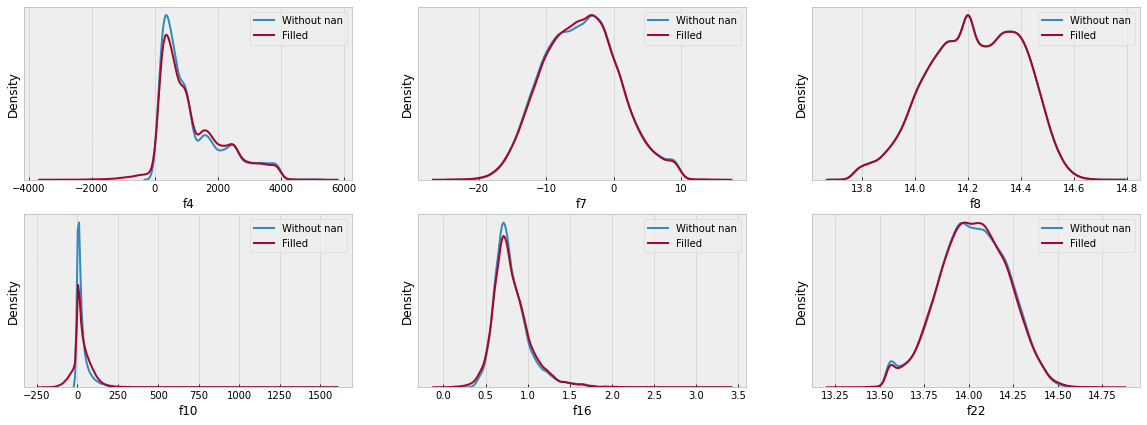

In [31]:
plot_imputations(df, df_imputed_mice, cont_cols)

We observe that the KNN Imputer and the Iterative Imputer (MICE) works best. However, we see that MICE can produce values that are quite far away from any value present in the actual data (due to the estimators being a linear regression model), while using KNN overcomes this issue. Thus, we choose the KNN imputer as our imputer for continuous values.

#### Discrete features
We create a method for imputing discrete features, and then compare the 'most frequent category imputer' to the 'predictive imputer'.

In [336]:
def impute_discrete_features(df, target_feature_names, method='predictive', add_nan_columns=True, verbose=True):
    """
    Args:
        - feature_df: feature_df that the imputer will be fit on 
        - target_feature_names: the features to fill in NaN values for
    """
    start = time.time()
    df2 = df.copy()
    
    if method == 'most_freq':
        imp = SimpleImputer(strategy='most_frequent')
        imputed = imp.fit_transform(df[target_feature_names])
        for i, c in enumerate(target_feature_names):
            if add_nan_columns:
                df2[f"{c}_Imputed"] = np.where(df2[c].isnull(), 1, 0)
            df2[c] = imputed[:, i]
            
    elif method == 'predictive':
        for feat in target_feature_names:
            #print(feat)
            clf = DecisionTreeClassifier()
            filtered_df = df2[df2[feat].notnull()]
            train_x = filtered_df.drop(columns=[feat])
            for c in train_x.select_dtypes('object').columns:
                le = LabelEncoder()
                encoded_data = le.fit_transform(train_x[c].astype(str))
                train_x[c] = encoded_data

            train_x.fillna(0, inplace=True)
            train_y = filtered_df[feat]
            clf.fit(train_x, train_y)

            filtered_df = df2[df2[feat].isnull()]
            x = filtered_df.drop(columns=[feat])
            for c in x.select_dtypes('object').columns:
                le = LabelEncoder()
                encoded_data = le.fit_transform(x[c].astype(str))
                x[c] = encoded_data
            x.fillna(0, inplace=True)
            
            #x = pd.get_dummies(x)
            y_hat = clf.predict(x)
            
            nan_idxs = df2[df2[feat].isnull()].index
            if add_nan_columns:
                df2[f"{feat}_Imputed"] = np.where(df2[feat].isnull(), 1, 0)
            
            df2.loc[nan_idxs, feat] = y_hat
           
            imp = clf
    if verbose:       
        print(f'Imputation done after {int(time.time()-start)}s')
    return imp, df2

In [332]:
_, df_imputed_mf = impute_discrete_features(df_imputed_mice, discrete_cols, method='most_freq')
_, df_imputed_pred = impute_discrete_features(df_imputed_mice, discrete_cols)

Imputation done after 0s
1
49998
32976
3
49995
7148
14
49992
7115
1
49999
6648
1
49998
6208
5
49992
6824
16
49993
6865


KeyboardInterrupt: 

In [279]:
def plot_discrete_imputations(df, df_imputed, disc_cols, n=5):
    disc_cols = disc_cols[:n]
    fig, ax = plt.subplots(n, 2, figsize=(12, 8))
    ax[0][0].set_title('Without nan')
    ax[0][1].set_title('Filled')
    for i, variable in enumerate(disc_cols):
        sns.countplot(df[variable], ax=ax[i][0])
        sns.countplot(df_imputed[variable], ax=ax[i][1])


Let's compare the distributions (counts) of values, for different features, when using the Frequent Categorical Imputer and the Predictive Imputer.

##### Frequent Categorical Imputer Count Plots

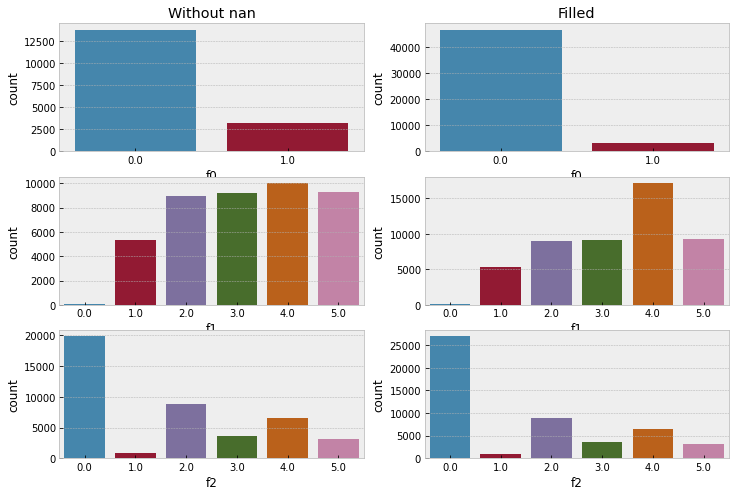

In [280]:
plot_discrete_imputations(df, df_imputed_mf, discrete_cols, n=3)

##### Predictive Imputer Count Plots

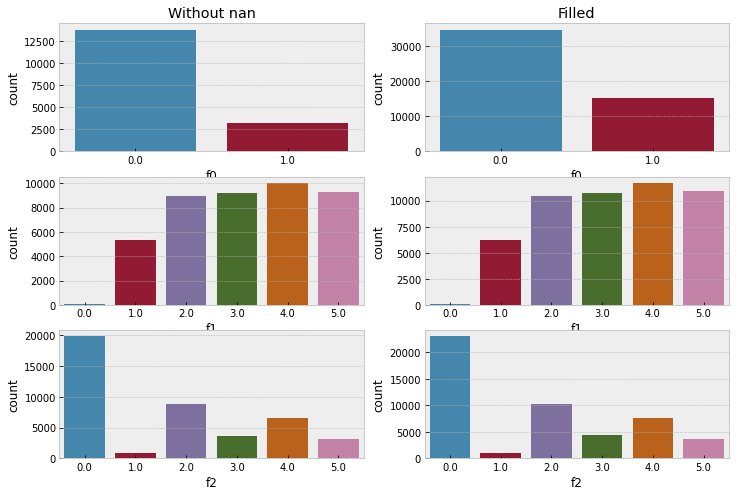

In [281]:
plot_discrete_imputations(df, df_imputed_pred, discrete_cols, n=3)

We observe that for the former, the distributions are not very similar. Due to the nature of the Categorical Frequency Imputer, only the count of the value that originally had the highest frequency has increased, while the rest stays the same. However, for the Predictive Imputer, the distribution stays almost identical, and the counts are spread more evenly among the values. Therefore, we choose this as our imputer for the discrete variables. 

Now, all the nan values should be filled:

In [282]:
df_clean = df_imputed_pred.copy()
print(f'# of nans in data: {sum(df_clean.isna().sum().values)}')
df_clean.head()

# of nans in data: 0


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f18_Imputed,f19_Imputed,f20_Imputed,f21_Imputed,f23_Imputed,f24_Imputed,f25_Imputed,f26_Imputed,f27_Imputed,f29_Imputed
0,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,13.9681,3.0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,5.0,4.0,1.0,2072.0,M,4.0,-1.6662,14.0242,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,14.2174,0.0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,3.0,2.0,1.0,409.0,F,5.0,-16.2169,13.8536,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0.0,5.0,0.0,3.0,222.0,F,5.0,-8.1088,14.2347,0.0,...,0,1,0,0,0,0,1,0,0,0


## 2.2 Feature Encoding

For the discrete features, we have options of one-hot encoding and ordinal encoding. 
For the continuous features, we don't do anything, except scaling (normalization/standardization).

In [40]:
def one_hot_encode(df, columns):
    df2 = df.copy()
        
    for col in columns:
        if col in df2.columns:
            df2 = pd.concat([df2, pd.get_dummies(df2[col], drop_first=True, prefix=col)],axis=1)
            df2.drop(columns=[col], inplace=True)
    
    return df2

def ordinal_encode(df, columns, pretrained_enc=None):
    df2 = df.copy()        
    
    if pretrained_enc is not None:
        df2 = enc.transform(df2)
    else:
        enc = OrdinalEncoder()
        #df2 = enc.fit_transform(df2)
        for col in columns:
            if col in df2.columns:
                enc = OrdinalEncoder()
                df2[[col]] = enc.fit_transform(df2[[col]])
    
    return enc, df2


Let's combine every preprocess step into one preprocessing function:

In [348]:
def process(df_train_orig, df_test_orig=None, cont_imp_meth='knn', disc_imp_meth='predictive', encoder_meth='ordinal', add_nan_columns=True, verbose=True):
    df_train = df_train_orig.copy()
    if verbose:
        print(f'Train data has {df_train.shape[0]} rows, each with {df_train.shape[1]} features.')
    
    if df_test_orig is not None:
        df_test = df_test_orig.copy()
        print(f'Test data has {df_test.shape[0]} rows, each with {df_test.shape[1]} features.')
    
    train_ids = df_train['id']
    test_ids = None
    if df_test_orig is not None:
        test_ids = df_test[['id']]
    
    train_target = df_train['target']
    
    df_train.drop(columns=['id', 'target', 'f12', 'f28'], inplace=True)
    if df_test_orig is not None:
        df_test.drop(columns=['id', 'f12', 'f28'], inplace=True)

    # Find columns with too many nans, drop from train and test 
    #drop_cols = get_features_with_nan(df_train, thresh=0.3)
    #df_train.drop(columns=drop_cols, inplace=True)
    #if df_test_orig is not None:
     #   df_test.drop(columns=drop_cols, inplace=True)
    
    # Get numerical and non- numerical features
    numerical_features = [c for c in df_train.columns if df_train[c].dtype == 'float64']
    non_numerical_features = [c for c in df_train.columns if df_train[c].dtype == 'object']
    
    # Replace -1 and 0 with NaN for f30 and f10, respectively
    df_train = replace_with(df_train, 'f30', -1)
    df_train = replace_with(df_train, 'f10', 0)
    
    if df_test_orig is not None:
        df_test = replace_with(df_test, 'f30', -1)
        df_test = replace_with(df_test, 'f10', 0)
    
    # Drop because of high correlation with f10
    df_train.drop(columns=['f14'], inplace=True)
    if df_test_orig is not None:
        df_test.drop(columns=['f14'], inplace=True)
    
    numerical_features.remove('f14')
    
    discrete_cols, cont_cols = get_discrete_and_continuous_feature(df_train)
        
    # Impute missing values
    # Imputer is learned over both train and test if test is available
    if df_test_orig is not None:
        #df_train['is_train'] = 1
        #df_test['is_train'] = 0
        df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
    else:
        df_all = df_train

    imp_cont, df_all_imputed = impute_continuous_features(df_all, cont_cols, 
                                                          method=cont_imp_meth, 
                                                          add_nan_columns=add_nan_columns,
                                                          verbose=verbose)
    imp_disc, df_all_imputed = impute_discrete_features(df_all_imputed, discrete_cols, 
                                                        method=disc_imp_meth,
                                                        add_nan_columns=add_nan_columns,
                                                        verbose=verbose)    
    df_all_clean = df_all_imputed

    # Encode features
    if encoder_meth == 'one_hot':
        df_all_clean_encoded = one_hot_encode(df_all_clean, discrete_cols)
    else:
        _, df_all_clean_encoded = ordinal_encode(df_all_clean, discrete_cols)
    
    # display(df_all_clean_encoded.head())
    # Seperate back to train and test
    if df_test_orig is not None:
        #train_df_clean_encoded = df_all_clean_encoded.loc[df_all_clean_encoded['is_train'] == 1]
        #test_df_clean_encoded = df_all_clean_encoded.loc[df_all_clean_encoded['is_train'] == 0]
        train_df_clean_encoded = df_all_clean_encoded.iloc[:df_train.shape[0], :].reset_index(drop=True)
        test_df_clean_encoded = df_all_clean_encoded.iloc[df_train.shape[0]:, :].reset_index(drop=True)
    else:
        train_df_clean_encoded = df_all_clean_encoded
        test_df_clean_encoded = None
    
    info = {}
    info['train_ids'] = train_ids
    info['test_ids'] = train_ids    
    info['discrete_cols'] = discrete_cols
    info['cont_cols'] = cont_cols
    info['numerical_features'] = numerical_features
    info['non_numerical_features'] = non_numerical_features
    
    if verbose:
        print(f'-- Done processing.')
    
    return train_df_clean_encoded, train_target, test_df_clean_encoded, info


## 2.3 Picking the best Imputation Combination
Now we use multiple baseline models in order to choose the best combination of imputation techniques. We try different combinations of the following: 

1. Continuous Imputation method
    - Mean
    - MICE
    - KNN
2. Discrete Imputation method:
    - Most frequent method
    - Predictive method
3. Include nan-capturing columns
    - Yes
    - No

In [359]:
def evaluate(models, x_train, x_val, y_train, y_val):
    roc_auc_total = 0
    nll_total = 0
    for model in models:
        try:
            model.fit(x_train, y_train, verbose=0)
        except:
            model.fit(x_train, y_train)
        y_hat_probs = model.predict_proba(x_val)
        roc_auc_total += roc_auc_score(y_val, y_hat_probs[:, 1])
        print(roc_auc_score(y_val, y_hat_probs[:, 1]))
    return roc_auc_total/len(models)
    

In [374]:
def evaluate_imputation_combinations(df_orig, fixed):
    
    cont_imp_methods = fixed['cont_imp_method'] if fixed['cont_imp_method'] else ['mean', 'knn', 'mice']
    disc_imp_methods = fixed['disc_imp_method'] if fixed['disc_imp_method'] else ['most_freq', 'predictive']
    add_nan_columns = fixed['add_nan_columns'] if fixed['add_nan_columns'] else [False, True]
    
    # Because KNN and MICE is rather time-consuming, we will fix the continuous imputation method to be 'mean',
    # when evaluating the three other steps
    
    # We also fix the encoding method to be 'ordinal', but we will later decide this for each model
    for cont_imp_method in cont_imp_methods:
        for disc_imp_method in disc_imp_methods:
            for add in add_nan_columns:
                df_train_processed, train_target, _, _ = process(df_train_orig, df_test_orig=None,
                                                                 cont_imp_meth=cont_imp_method, 
                                                                 disc_imp_meth=disc_imp_method,        
                                                                 add_nan_columns=add,
                                                                 verbose=False)


                x_train, x_val, y_train, y_val = train_test_split(df_train_processed, train_target, test_size=0.2)

                models = [DecisionTreeClassifier(), CatBoostClassifier(), XGBClassifier()] 
                roc_auc = evaluate(models, x_train, x_val, y_train, y_val)
                print('-'*50)
                print(f'Cont Imp method: {cont_imp_method}')
                print(f'Discrete Imp method: {disc_imp_method}')
                print(f'Add nan columns: {add}')
                print(f'\t -- ROC-AUC: {roc_auc:.3f}')
                 

In [259]:
df_train_orig = pd.read_csv("data/challenge3_train.csv")
fixed = {
    'cont_imp_method': ['mean'],
    'disc_imp_method': None,
    'add_nan_columns': None
}
evaluate_imputation_combinations(df_train_orig, fixed)

--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: most_freq
Add nan columns: False
	 -- ROC-AUC: 0.862
--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: most_freq
Add nan columns: True
	 -- ROC-AUC: 0.868
--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: predictive
Add nan columns: False
	 -- ROC-AUC: 0.865
--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.872


**Based on this, we choose the 'predictive' discrete imputation method, and we choose to add nan columns.
Now let's fix those, and compare between 'mean', 'mice' and 'knn' for the the continuous imputation method..**

In [260]:
fixed = {
    'cont_imp_method': None,
    'disc_imp_method': ['predictive'],
    'add_nan_columns': [True]
}
evaluate_imputation_combinations(df_train_orig, fixed)

--------------------------------------------------
Cont Imp method: mean
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.870
--------------------------------------------------
Cont Imp method: knn
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.873
--------------------------------------------------
Cont Imp method: mice
Discrete Imp method: predictive
Add nan columns: True
	 -- ROC-AUC: 0.870


**Based on this, we choose the 'knn' continuous imputation method.**

# 3. Model Choice and Training 
To choose between models, we perform k-fold cross-validation.

In [400]:
def compute_kfold_CV(df_train, targets, model, k=5, normalize=False):
    X = df_train.copy()
    y = targets.copy()
    
    hist = {}
    hist['fold_acc'] = np.zeros((k,))
    hist['fold_f1'] = np.zeros((k,))
    hist['fold_roc_auc'] = np.zeros((k,))
    hist['fold_nll'] = np.zeros((k,))
    
    # print(f'Starting {k}-fold CV..')
    kf = KFold(n_splits=k)
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        #print("TRAIN:", train_index, "TEST:", val_index)
        x_train, x_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        if normalize:
            scaler = StandardScaler()
            x_train = scaler.fit_transform(train_x)
            x_val = scaler.fit_transform(val_x)
        
        try:
            model.fit(x_train, y_train, verbose=0)
        except:
            model.fit(x_train, y_train)
        
        y_hat = model.predict(x_val)
        y_hat_proba = model.predict_proba(x_val)[:, 1]
        
        acc = accuracy_score(y_val, y_hat)
        f1 = f1_score(y_val, y_hat)
        roc_auc = roc_auc_score(y_val, y_hat_proba)
        nll = log_loss(y_val, y_hat_proba)
        
        hist['fold_acc'][i] = acc
        hist['fold_f1'][i] = f1
        hist['fold_roc_auc'][i] = roc_auc
        hist['fold_nll'][i] = nll
        
        print(roc_auc)
        print(f'Fold_{i+1} done', end=' | ')
    
    print('-- Done.')
    return hist
        

In [192]:
def plot_roc_auc(y_true, y_hat_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_hat_probs)
    plt.plot(fpr, tpr) 
    plt.axis("Square")
    plt.xlim([-0.05, 1.05]) 
    plt.ylim([-0.05, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('receiver operating characteristic curve: score=%f' % score) 
    plt.show()

In [327]:
def display_results(hist, plot=True):
    mean_acc = hist['fold_acc'].mean()
    mean_f1 = hist['fold_f1'].mean()
    mean_roc_auc = hist['fold_roc_auc'].mean()
    mean_nll = hist['fold_nll'].mean()

    print("Results:")
    print(f'\t Average fold accuracy: {mean_acc:.3f}')
    print(f'\t Average fold f1: {mean_f1:.3f}')
    print(f'\t Average fold roc_auc: {mean_roc_auc:.3f}')
    print(f'\t Average fold nll: {mean_nll:.3f}')


## 3.1 K-fold Cross-Validation on multiple models
We start by pre-processing the data in the optimal way found earlier. Then, for each model, we run a 5-fold cross-validation and evaluate each model using several metrics. Based on this, the best model is chosen.

In [375]:
df_train_orig = pd.read_csv("data/challenge3_train.csv")
df_test_orig = pd.read_csv("data/challenge3_test.csv")
#display(df_train_orig)

df_train_processed, train_target, df_test_processed, info = process(df_train_orig, df_test_orig=None,
                                                    cont_imp_meth='mean', 
                                                    disc_imp_meth='predictive',
                                                    encoder_meth='ordinal')

#display(df_train_processed)
train_ids = info['train_ids']
test_ids = info['test_ids']
discrete_cols = info['discrete_cols']
cont_cols = info['cont_cols']
numerical_features = info['numerical_features']
non_numerical_features = info['non_numerical_features']

Train data has 50000 rows, each with 33 features.
Imputation done after 0s
Imputation done after 12s
-- Done processing.


In [ ]:
model = 
input_shape=df_train_processed.shape[1]

### RandomForestClassifier

In [384]:
params = {
    'n_estimators': 500,
}

model = RandomForestClassifier(**params)

print(f'[Using ordinal encoding]')
hist = compute_kfold_CV(df_train_processed, train_target, model, k=5)
display_results(hist)

print(f'[Using one-hot encoding]')
one_hot_df_train_processed = one_hot_encode(df_train_processed, columns=discrete_cols)
one_hot_hist = compute_kfold_CV(one_hot_df_train_processed, train_target, model, k=5)
display_results(one_hot_hist)

[Using ordinal encoding]
Starting 5-fold CV..
Fold_1 done
Fold_2 done
Fold_3 done
Fold_4 done
Fold_5 done
-- Done.
Results:
	 Average fold accuracy: 0.834
	 Average fold f1: 0.793
	 Average fold roc_auc: 0.905
	 Average fold nll: 0.407
[Using one-hot encoding]
Starting 5-fold CV..
Fold_1 done
Fold_2 done
Fold_3 done
Fold_4 done
Fold_5 done
-- Done.
Results:
	 Average fold accuracy: 0.826
	 Average fold f1: 0.779
	 Average fold roc_auc: 0.899
	 Average fold nll: 0.419


### LogisticRegression

In [386]:
params = {
    'max_iter': 1000,
}

model = LogisticRegression(**params)

print(f'[Using ordinal encoding]')
hist = compute_kfold_CV(df_train_processed, train_target, model, k=5)
display_results(hist)

print(f'[Using one-hot encoding]')
one_hot_df_train_processed = one_hot_encode(df_train_processed, columns=discrete_cols)
one_hot_hist = compute_kfold_CV(one_hot_df_train_processed, train_target, model, k=5)
display_results(one_hot_hist)

[Using ordinal encoding]
Starting 5-fold CV..
Fold_1 done
Fold_2 done
Fold_3 done
Fold_4 done
Fold_5 done
-- Done.
Results:
	 Average fold accuracy: 0.763
	 Average fold f1: 0.716
	 Average fold roc_auc: 0.824
	 Average fold nll: 0.509
[Using one-hot encoding]
Starting 5-fold CV..
Fold_1 done
Fold_2 done
Fold_3 done
Fold_4 done
Fold_5 done
-- Done.
Results:
	 Average fold accuracy: 0.795
	 Average fold f1: 0.757
	 Average fold roc_auc: 0.860
	 Average fold nll: 0.461


### XGBClassifier

In [387]:
params = {
    'n_estimators': 500,
}

model = XGBClassifier(**params)

print(f'[Using ordinal encoding]')
hist = compute_kfold_CV(df_train_processed, train_target, model, k=5)
display_results(hist)

print(f'[Using one-hot encoding]')
one_hot_df_train_processed = one_hot_encode(df_train_processed, columns=discrete_cols)
one_hot_hist = compute_kfold_CV(one_hot_df_train_processed, train_target, model, k=5)
display_results(one_hot_hist)

[Using ordinal encoding]
Starting 5-fold CV..
Fold_1 done
Fold_2 done
Fold_3 done
Fold_4 done
Fold_5 done
-- Done.
Results:
	 Average fold accuracy: 0.835
	 Average fold f1: 0.804
	 Average fold roc_auc: 0.906
	 Average fold nll: 0.414
[Using one-hot encoding]
Starting 5-fold CV..
Fold_1 done
Fold_2 done
Fold_3 done
Fold_4 done
Fold_5 done
-- Done.
Results:
	 Average fold accuracy: 0.832
	 Average fold f1: 0.800
	 Average fold roc_auc: 0.905
	 Average fold nll: 0.405


### AdaBoostClassifier

In [389]:
params = {
    'n_estimators': 500,
}

model = AdaBoostClassifier(**params)

print(f'[Using ordinal encoding]')
hist = compute_kfold_CV(df_train_processed, train_target, model, k=5)
display_results(hist)

print(f'[Using one-hot encoding]')
one_hot_df_train_processed = one_hot_encode(df_train_processed, columns=discrete_cols)
one_hot_hist = compute_kfold_CV(one_hot_df_train_processed, train_target, model, k=5)
display_results(one_hot_hist)

[Using ordinal encoding]
Starting 5-fold CV..
Fold_1 done | Fold_2 done | Fold_3 done | Fold_4 done | Fold_5 done | -- Done.
Results:
	 Average fold accuracy: 0.791
	 Average fold f1: 0.754
	 Average fold roc_auc: 0.859
	 Average fold nll: 0.692
[Using one-hot encoding]
Starting 5-fold CV..
Fold_1 done | Fold_2 done | Fold_3 done | Fold_4 done | Fold_5 done | -- Done.
Results:
	 Average fold accuracy: 0.790
	 Average fold f1: 0.753
	 Average fold roc_auc: 0.858
	 Average fold nll: 0.692


### CatBoostClassifier

In [391]:
params = {
    'iterations': 500,
    'border_count': 50
}

model = CatBoostClassifier(**params)

print(f'[Using ordinal encoding]')
hist = compute_kfold_CV(df_train_processed, train_target, model, k=5)
display_results(hist)

print(f'[Using one-hot encoding]')
one_hot_df_train_processed = one_hot_encode(df_train_processed, columns=discrete_cols)
one_hot_hist = compute_kfold_CV(one_hot_df_train_processed, train_target, model, k=5)
display_results(one_hot_hist)


[Using ordinal encoding]
Fold_1 done | Fold_2 done | Fold_3 done | Fold_4 done | Fold_5 done | -- Done.
Results:
	 Average fold accuracy: 0.846
	 Average fold f1: 0.817
	 Average fold roc_auc: 0.918
	 Average fold nll: 0.355
[Using one-hot encoding]
Fold_1 done | Fold_2 done | Fold_3 done | Fold_4 done | Fold_5 done | -- Done.
Results:
	 Average fold accuracy: 0.841
	 Average fold f1: 0.810
	 Average fold roc_auc: 0.913
	 Average fold nll: 0.367


### MLPClassifier

In [401]:
params = {
    'hidden_layer_sizes': (64, 32, 16)
}

model = MLPClassifier(**params)

#print(f'[Using ordinal encoding]')
#hist = compute_kfold_CV(df_train_processed, train_target, model, k=5)
#display_results(hist)

print(f'[Using one-hot encoding]')
one_hot_df_train_processed = one_hot_encode(df_train_processed, columns=discrete_cols)
one_hot_hist = compute_kfold_CV(one_hot_df_train_processed, train_target, model, k=5)
display_results(one_hot_hist)

[Using one-hot encoding]
0.865269535951194
Fold_1 done | 0.8647988911495074
Fold_2 done | 0.8734339867492842
Fold_3 done | 0.8742754080968183
Fold_4 done | 0.8747459742471368
Fold_5 done | -- Done.
Results:
	 Average fold accuracy: 0.805
	 Average fold f1: 0.772
	 Average fold roc_auc: 0.871
	 Average fold nll: 0.600
